# **Spin** calculation

IDEA:
- take in consideration only the ball for each frame
- draw a lot of points on the ball
- take the motion of these points between consecutive frames (optical flow)
- from this motion we extract the direction of the rotation and so the axis of rotation

In [249]:
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt

In [250]:
VIDEO_NUMBER = "3"
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_VIDEO_PATH = str(
    PROJECT_ROOT
    / "data"
    / f"recording_{VIDEO_NUMBER}"
    / f"Recording_{VIDEO_NUMBER}.mp4"
)
INPUT_CSV_PATH = str(
    PROJECT_ROOT
    / "notebook"
    / "ball_detection"
    / "intermediate_data"
    / f"Circle_positions_cleaned_{VIDEO_NUMBER}.csv"
)

In [251]:
# Load video
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
if not cap.isOpened():
    print("Error: Could not open video.")
    exit

# Check video properties
print(
    f"Video opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}"
)

# Load CSV
df = pd.read_csv(INPUT_CSV_PATH)

# Check if the CSV file is empty
if df.empty:
    print("Error: The CSV file is empty.")
    exit()

Video opened: True, FPS: 59.94005994005994, Total Frames: 227.0


Selecting a frame

In [252]:
# Set the video to the desired frame
frame_number = 100
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the frame
ret, frame1 = cap.read()

# Check if the frame was successfully read
if ret:
    print(f"Frame {frame_number} successfully read.")
else:
    print(f"Failed to read frame {frame_number}.")

Frame 100 successfully read.


In [253]:
# Extract ball center and radius from ball_df
ball_center = (int(df.iloc[frame_number]["x"]), int(df.iloc[frame_number]["y"]))
ball_radius = int(df.iloc[frame_number]["radius"])

# Define the region of interest (ROI) around the ball
offset = 2
x_min = max(ball_center[0] - ball_radius, 0) - offset
x_max = min(ball_center[0] + ball_radius, frame1.shape[1]) + offset
y_min = max(ball_center[1] - ball_radius, 0) - offset
y_max = min(ball_center[1] + ball_radius, frame1.shape[0]) + offset

# Crop ROI and convert to grayscale
roi1 = frame1[y_min:y_max, x_min:x_max]
gray1 = cv2.cvtColor(roi1, cv2.COLOR_BGR2GRAY)

# Compute center of ball in ROI coords
center_roi = (ball_center[0] - x_min, ball_center[1] - y_min)

In [254]:
# Generate 100 random points inside the circular ROI
h, w = gray1.shape
points = []
while len(points) < 100:
    x = np.random.randint(0, w)
    y = np.random.randint(0, h)
    # distance to center of ROI
    if (x - center_roi[0]) ** 2 + (y - center_roi[1]) ** 2 <= ball_radius**2:
        points.append([x, y])
p0 = np.array(points, dtype=np.float32).reshape(-1, 1, 2)

In [255]:
# Read next frame and prepare
ret, frame2 = cap.read()
if not ret:
    raise IOError(f"Failed to read frame {frame_number + 1}.")
roi2 = frame2[y_min:y_max, x_min:x_max]
gray2 = cv2.cvtColor(roi2, cv2.COLOR_BGR2GRAY)

# Calculate optical flow using Lucas-Kanade
p1, status, err = cv2.calcOpticalFlowPyrLK(
    gray1,
    gray2,
    p0,
    None,
    winSize=(15, 15),
    maxLevel=2,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
)

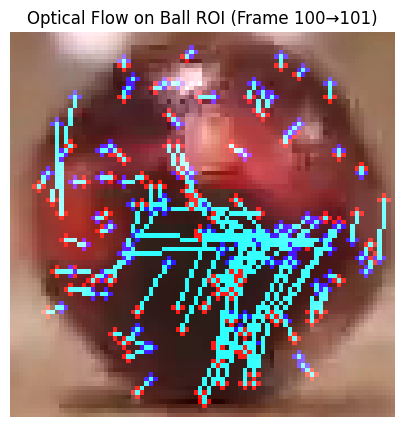

In [256]:
# Create mask for drawing
mask = np.zeros_like(roi2)

# Draw start/end points and arrows for tracked points
for i, (new_pt, old_pt) in enumerate(zip(p1, p0)):
    if status[i][0] == 1:
        a, b = new_pt.ravel()
        c, d = old_pt.ravel()
        # starting point in red
        cv2.circle(mask, (int(c), int(d)), 1, (0, 0, 255), -1)
        # ending point in blue
        cv2.circle(mask, (int(a), int(b)), 1, (255, 0, 0), -1)
        # line for movement in blue
        cv2.line(mask, (int(c), int(d)), (int(a), int(b)), (255, 255, 0), 1)

# Overlay mask on ROI
output_roi = cv2.addWeighted(roi2, 1, mask, 1, 0)

# Convert BGR to RGB for matplotlib
output_rgb = cv2.cvtColor(output_roi, cv2.COLOR_BGR2RGB)

# Display only the ROI with flow using matplotlib
plt.figure(figsize=(5, 5))
plt.imshow(output_rgb)
plt.axis("off")
plt.title(f"Optical Flow on Ball ROI (Frame {frame_number}→{frame_number + 1})")
plt.show()